<a href="https://colab.research.google.com/github/MinsooKwak/covid_x_ray_classification/blob/main/covid_x_ray_cls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import copy
import random

import cv2
import torch
import numpy as np
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from ipywidgets import interact

random_seed = 2022

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### 1. 이미지 파일 경로 불러오기

In [3]:
data_dir = '/content/drive/MyDrive/DataSet/covid_chest'

In [4]:
def list_image_files(data_dir, sub_dir):
    image_format = ["jpeg", "jpg", "png"]

    image_files = []
    images_dir = os.path.join(data_dir, sub_dir)
    for file_path in os.listdir(images_dir):
        if file_path.split(".")[-1] in image_format:
            image_files.append(os.path.join(sub_dir, file_path))
    return image_files

In [5]:
normal_list = list_image_files(data_dir, "NORMAL")
covid_list = list_image_files(data_dir, "COVID")
pneumonia_list = list_image_files(data_dir, "PNEUMONIA")

In [6]:
normal_list

['NORMAL/NORMAL_1703.png',
 'NORMAL/NORMAL_172.png',
 'NORMAL/NORMAL_17.png',
 'NORMAL/NORMAL_1725.png',
 'NORMAL/NORMAL_1728.png',
 'NORMAL/NORMAL_1731.png',
 'NORMAL/NORMAL_1738.png',
 'NORMAL/NORMAL_1730.png',
 'NORMAL/NORMAL_1737.png',
 'NORMAL/NORMAL_1746.png',
 'NORMAL/NORMAL_1724.png',
 'NORMAL/NORMAL_1753.png',
 'NORMAL/NORMAL_1733.png',
 'NORMAL/NORMAL_1732.png',
 'NORMAL/NORMAL_1747.png',
 'NORMAL/NORMAL_1748.png',
 'NORMAL/NORMAL_1752.png',
 'NORMAL/NORMAL_1741.png',
 'NORMAL/NORMAL_1729.png',
 'NORMAL/NORMAL_1740.png',
 'NORMAL/NORMAL_1745.png',
 'NORMAL/NORMAL_1726.png',
 'NORMAL/NORMAL_1736.png',
 'NORMAL/NORMAL_1743.png',
 'NORMAL/NORMAL_1739.png',
 'NORMAL/NORMAL_1734.png',
 'NORMAL/NORMAL_1727.png',
 'NORMAL/NORMAL_1723.png',
 'NORMAL/NORMAL_1751.png',
 'NORMAL/NORMAL_1744.png',
 'NORMAL/NORMAL_174.png',
 'NORMAL/NORMAL_1750.png',
 'NORMAL/NORMAL_1742.png',
 'NORMAL/NORMAL_1735.png',
 'NORMAL/NORMAL_1749.png',
 'NORMAL/NORMAL_173.png',
 'NORMAL/NORMAL_175.png',
 'NORMA

In [7]:
print(f'normal : {len(normal_list)}, Covid : {len(covid_list)}, pneumonia : {len(pneumonia_list)}')

normal : 1802, Covid : 1626, pneumonia : 1800


### 데이터 split

In [8]:
!pip install split-folders[full]

In [9]:
import splitfolders

# data split (train:val:test) # train : val로만 나눌 경우 2개 인자만 입력
splitfolders.ratio(input=data_dir, output = "/content/drive/MyDrive/DataSet/covid_chest_split", seed =2024, ratio=(0.8,0.1,0.1))

# 고정된 개수로 나눌 경우
# splitfolders.fixed("input_folder", output="output", seed=2014, fixed=(100,100))

Copying files: 5228 files [03:04, 28.39 files/s]


- train set에서 수량 확인

In [10]:
data_split_dir = '/content/drive/MyDrive/DataSet/covid_chest_split/train'
normal_list = list_image_files(data_split_dir, "NORMAL")
covid_list = list_image_files(data_split_dir, "COVID")
pneumonia_list = list_image_files(data_split_dir, "PNEUMONIA")
print(f'normal : {len(normal_list)}, Covid : {len(covid_list)}, pneumonia : {len(pneumonia_list)}')

normal : 1441, Covid : 1300, pneumonia : 1440


### 2. 이미지 파일 3차원 배열

In [11]:
import cv2

In [12]:
def get_RGB_image(data_dir, file_name):
  image_file = os.path.join(data_dir, file_name)
  image = cv2.imread(image_file)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

### 3. 이미지 데이터 확인

In [13]:
import matplotlib.pyplot as plt
from ipywidgets import interact

In [14]:
min_num_files = min(len(normal_list), len(covid_list), len(pneumonia_list))
min_num_files

1300

interactive(children=(IntSlider(value=0, description='index', max=1299), Output()), _dom_classes=('widget-inte…

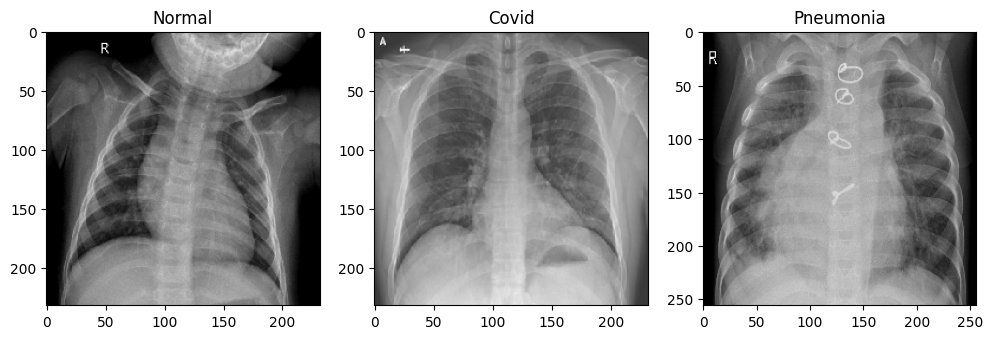

In [15]:
@interact(index=(0, min_num_files-1)) # 슬라이드 바 생성, 0~min_num_file-1 까지 활동 가능
def show_samples(index=0):
  normal_image = get_RGB_image(data_split_dir, normal_list[index])
  covid_image = get_RGB_image(data_split_dir, covid_list[index])
  pneumonia_image = get_RGB_image(data_split_dir, pneumonia_list[index])

  plt.figure(figsize=(12,8))
  plt.subplot(131)
  plt.title('Normal')
  plt.imshow(normal_image)

  plt.subplot(132)
  plt.title('Covid')
  plt.imshow(covid_image)

  plt.subplot(133)
  plt.title('Pneumonia')
  plt.imshow(pneumonia_image)

### 4. 데이터셋 클래스 구축

1. load class 구축
2. 연산 가능한 텐서로 변환
3. 데이터로더로 구현

In [16]:
from torch.utils.data import Dataset, DataLoader

In [17]:
train_data_dir = '/content/drive/MyDrive/DataSet/covid_chest_split/train/'
class_list = ['COVID','NORMAL','PNEUMONIA'] # 폴더명과 동일하게 클래스 리스트 생성

- 데이터 로드 할 수 있도록 클래스 구축

In [18]:
import torch

In [19]:
class Chest_dataset(Dataset):
  def __init__(self,data_split_dir, transform=None):
    self.data_split_dir = data_split_dir
    normals = list_image_files(data_split_dir,"NORMAL")
    covids = list_image_files(data_split_dir, "COVID")
    pneumonias = list_image_files(data_split_dir,"PNEUMONIA")

    self.files_path = normals + covids + pneumonias # 각 파일 리스트 더한 게 files_path
    self.transform = transform

  def __len__(self):
    return len(self.files_path)

  def __getitem__(self,index):
    image_file = os.path.join(self.data_split_dir, self.files_path[index])
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    #print(self.data_split_dir, self.files_path[index])
    target = class_list.index(self.files_path[index].split(os.sep)[-2])
    target = class_list.index(self.files_path[index].split(os.sep)[0])

    if self.transform:
      image = self.transform(image)
      target = torch.Tensor([target]).long() # int로 변환

    return {"image":image, "target":target}

In [20]:
dset = Chest_dataset(data_split_dir = train_data_dir)

In [21]:
len(dset) # 데이터셋 전체 길이

4181

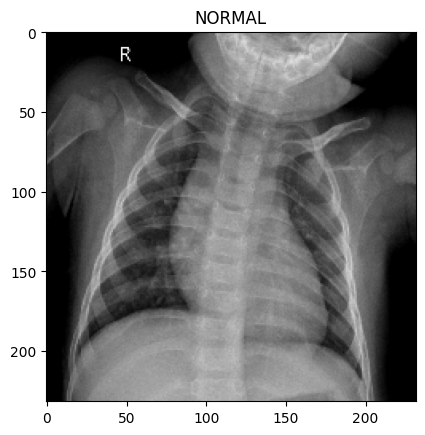

In [22]:
index=0

plt.title(class_list[dset[index]['target']])
plt.imshow(dset[index]['image'])

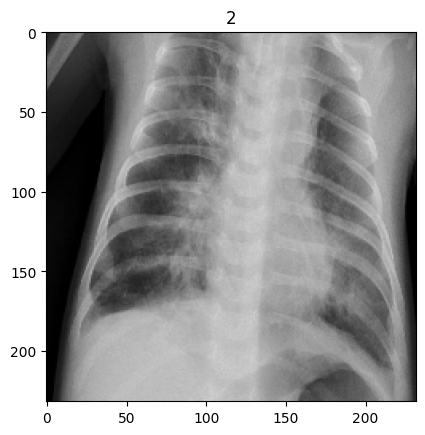

In [23]:
index=-100

plt.title(dset[index]['target'])
plt.imshow(dset[index]['image'])

### 연산 가능한 텐서형으로 데이터 변환

In [24]:
import torch
from torchvision import transforms

In [25]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [26]:
train_dset = Chest_dataset(train_data_dir, transformer)
index = 200
image = train_dset[index]['image']
target = train_dset[index]['target']
print(image.shape)
print(target)

torch.Size([3, 224, 224])
tensor([1])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### 데이터로드 구현

In [27]:
from torch.utils.data import DataLoader

In [28]:
#train_data_dir = '/content/drive/MyDrive/DataSet/covid_chest_split/train'
#val_data_dir = '/content/drive/MyDrive/DataSet/covid_chest_split/test'

#train_dset = Chest_dataset(train_data_dir, transformer)
#train_dloader = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)
#val_dset = Chest_dataset(val_data_dir, transformer)
#val_dloader = DataLoader(val_dset, batch_size=1, shuffle=False)

In [29]:
def build_dataloader(train_data_dir, val_data_dir):
  dataloaders = {}
  train_dset = Chest_dataset(train_data_dir, transformer)
  dataloaders['train'] = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)
  val_dset = Chest_dataset(val_data_dir, transformer)
  dataloaders['val'] = DataLoader(val_dset, batch_size=1, shuffle=False)
  return dataloaders

In [30]:
train_data_dir = '/content/drive/MyDrive/DataSet/covid_chest_split/train'
val_data_dir = '/content/drive/MyDrive/DataSet/covid_chest_split/test'
dataloaders = build_dataloader(train_data_dir, val_data_dir)

In [31]:
for i, d in enumerate(dataloaders['train']):
  if i==0:
    break

In [32]:
d['target'].shape

torch.Size([4, 1])

In [33]:
d['target'].squeeze()

tensor([1, 2, 2, 0])

### Classification Model VGG19 Import

In [34]:
from torchvision import models

In [35]:
model = models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 69.8MB/s]


In [36]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [37]:
from torchsummary import summary
summary(model,(3,244,244), batch_size=1, device='cpu')  # channel,높이, 가로

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 244, 244]           1,792
              ReLU-2          [1, 64, 244, 244]               0
            Conv2d-3          [1, 64, 244, 244]          36,928
              ReLU-4          [1, 64, 244, 244]               0
         MaxPool2d-5          [1, 64, 122, 122]               0
            Conv2d-6         [1, 128, 122, 122]          73,856
              ReLU-7         [1, 128, 122, 122]               0
            Conv2d-8         [1, 128, 122, 122]         147,584
              ReLU-9         [1, 128, 122, 122]               0
        MaxPool2d-10           [1, 128, 61, 61]               0
           Conv2d-11           [1, 256, 61, 61]         295,168
             ReLU-12           [1, 256, 61, 61]               0
           Conv2d-13           [1, 256, 61, 61]         590,080
             ReLU-14           [1, 256,

### 데이터셋에 맞도록 모델 Head 부분 변경

In [38]:
import torch.nn as nn

In [39]:
'''
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1)) # 지정한 pooling size로 pooling 수행 # 어떤 크기 와도 가능
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256,3), # Feature size, 클래스 개수
    nn.Sigmoid(),      # 0~1
)
'''

'\nmodel.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1)) # 지정한 pooling size로 pooling 수행 # 어떤 크기 와도 가능\nmodel.classifier = nn.Sequential(\n    nn.Flatten(),\n    nn.Linear(512,256),\n    nn.ReLU(),\n    nn.Dropout(0.1),\n    nn.Linear(256,3), # Feature size, 클래스 개수\n    nn.Sigmoid(),      # 0~1\n)\n'

In [40]:
def build_vgg19_based_model(device_name='cpu'):
  device = torch.device(device_name)
  model = models.vgg19(pretrained=True)
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256,3), # Feature size, 클래스 개수
    nn.Sigmoid(),      # 0~1
  )
  return model.to(device) # 모델 mount

In [41]:
model = build_vgg19_based_model(device_name='cpu')

In [42]:
summary(model, (3,244,244), batch_size=1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 244, 244]           1,792
              ReLU-2          [1, 64, 244, 244]               0
            Conv2d-3          [1, 64, 244, 244]          36,928
              ReLU-4          [1, 64, 244, 244]               0
         MaxPool2d-5          [1, 64, 122, 122]               0
            Conv2d-6         [1, 128, 122, 122]          73,856
              ReLU-7         [1, 128, 122, 122]               0
            Conv2d-8         [1, 128, 122, 122]         147,584
              ReLU-9         [1, 128, 122, 122]               0
        MaxPool2d-10           [1, 128, 61, 61]               0
           Conv2d-11           [1, 256, 61, 61]         295,168
             ReLU-12           [1, 256, 61, 61]               0
           Conv2d-13           [1, 256, 61, 61]         590,080
             ReLU-14           [1, 256,

### 손실함수 (cross-entropy) 불러오기

- 분류 모델에 주로 사용

In [43]:
loss_func = nn.CrossEntropyLoss(reduction='mean')

### SGDM 최적화 기법 적용

- local minima에 빠지지 않고 global minima 찾기 위해 사용

In [44]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 검증 위해 Accuracy 생성

In [45]:
# backward 필요 없으므로 데코레이터
@torch.no_grad()
def get_accuracy(image, target, model):
  batch_size = image.shape[0]
  prediction = model(image) # [B, NUM_CLASSES]
  _, pred_label = torch.max(prediction, dim=1)  # 가장 높은 confidence score 가진 값 가져옴
  is_correct = (pred_label==target) # True/False
  # true인것만 더하고 batch 형태로 나눠 연산
  accuracy = is_correct.cpu().numpy().sum() / batch_size
  return accuracy

### 모델 학습 수행

In [46]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

train_data_dir = '/content/drive/MyDrive/DataSet/covid_chest_split/train'
val_data_dir = '/content/drive/MyDrive/DataSet/covid_chest_split/test'

dataloaders = build_dataloader(train_data_dir, val_data_dir)
model = build_vgg19_based_model(device_name='cuda')
loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1E-3, momentum=0.9)

In [47]:
def train_one_epoch(dataloaders, model, optimizer, loss_function, device):
  losses = {}
  accuracies = {}

  # 한 epoch에서 2가지 모드 실행 # loss 판단하고 overfitting 됐는지 판단
  for phase in ['train','val']:
    running_loss = 0.0
    running_correct = 0


    # train, eval 동작 다르게 layer
    if phase =='train':
      model.train()
    else:
      model.eval()

    for index, batch in enumerate(dataloaders[phase]):
      image = batch['image'].to(device)
      target = batch['target'].squeeze(1).to(device) # 클래스 id # demension 변환 후

      optimizer.zero_grad()

      # validation할 때에는 gradient update deactivate
      with torch.set_grad_enabled(phase=='train'):
        prediction = model(image)
        loss = loss_func(prediction, target)

        # loss를 갖고 최적화 수행
        if phase =='train':
          optimizer.zero_grad() # 미분의 누적값이 생기지 않게 (최적화 수행 전에 기울기값 갱신)
          loss.backward()   # loss와 관련 모든 파라미터의 미분값이 업데이트됨
          optimizer.step()  # 미분값을 옵티마이저에 전달

      running_loss += loss.item() # loss 누적
      running_correct += get_accuracy(image, target, model)

      # 학습 수행시 loss 수렴하는지, nan으로 가진 않는지 확인
      if phase =='train':
        if index % 10 ==0:
          print(f"{index}/{len(dataloaders['train'])} - Running loss:{loss.item()}")

     # 배치 크기의 평균값 을 계산해 train, val key값에 전달
    losses[phase] = running_loss / len(dataloaders[phase])
    accuracies[phase] = running_correct / len(dataloaders[phase])
  return losses, accuracies

In [49]:
def save_best_model(model_state, model_name, save_dir="/content/drive/MyDrive/Study/CV_fc/CV_project/covid_x_ray/trained_model"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

In [50]:
num_epochs = 10

best_acc = 0.0
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    train_loss.append(losses["train"])
    val_loss.append(losses["val"])
    train_accuracy.append(accuracies["train"])
    val_accuracy.append(accuracies["val"])

    print(f"{epoch+1}/{num_epochs}-Train Loss: {losses['train']}, Val Loss: {losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc: {accuracies['train']}, Val Acc: {accuracies['val']}")

    if (epoch > 3) and (accuracies["val"] > best_acc):
        best_acc = accuracies["val"]
        best_model = copy.deepcopy(model.state_dict())
        save_best_model(best_model, f"model_{epoch+1:02d}.pth")

print(f"Best Accuracy: {best_acc}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0/1045 - Running loss:0.5514501333236694
10/1045 - Running loss:0.5517100095748901
20/1045 - Running loss:0.5514485836029053
30/1045 - Running loss:0.5515161156654358
40/1045 - Running loss:0.6747946739196777
50/1045 - Running loss:0.5542978644371033
60/1045 - Running loss:0.5514543056488037
70/1045 - Running loss:0.5514448285102844
80/1045 - Running loss:0.5515140295028687
90/1045 - Running loss:0.8009828329086304
100/1045 - Running loss:0.5523840188980103
110/1045 - Running loss:0.6012321710586548
120/1045 - Running loss:0.7796589136123657
130/1045 - Running loss:0.5584770441055298
140/1045 - Running loss:0.8014559149742126
150/1045 - Running loss:0.5514625906944275
160/1045 - Running loss:0.5514601469039917
170/1045 - Running loss:0.5648842453956604
180/1045 - Running loss:0.5528101921081543
190/1045 - Running loss:0.5514620542526245
200/1045 - Running loss:0.5514452457427979
210/1045 - Running loss:0.551579475402832
220/1045 - Running loss:0.5514475107192993
230/1045 - Running loss

### 테스트셋 통한 분류 성능 테스트

In [51]:
data_data = '/content/drive/MyDrive/DataSet/covid_chest_split/test'
test_normals_list = list_image_files(data_data, "NORMAL")
test_covids_list = list_image_files(data_data,"COVID")
test_pneumonia_list = list_image_files(data_data, "PNEUMONIA")

In [52]:
len(test_pneumonia_list)

180

In [53]:
def preprocess_image(image):
  transformer = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((224,224)),
      transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
  ])

  tensor_image = transformer(image) # [C, H, W]
  tensor_image = tensor_image.unsqueeze(dim=0) # [B, C, H, W]
  return tensor_image

In [54]:
# backward로 가중치 업데이트 하지 않으므로 데코레이터
@torch.no_grad()
def model_predict(image, model):
  tensor_image = preprocess_image(image)
  prediction = model(tensor_image)
  # tracking 연결고리 끊음
  _, pred_label = torch.max(prediction.detach().cpu(), dim=1) # [B, Num_classes]  # dim1-> index
  # 위에서 unsqueeze 통해 더미 batch 형태 -> 제거해줘야 함 (더미 batch인 0번)
  pred_label = pred_label.squeeze(dim=0)  # (B,1) -> (1)
  return pred_label.item()

In [56]:
ckpt = torch.load('/content/drive/MyDrive/Study/CV_fc/CV_project/covid_x_ray/trained_model/model_06.pth')

model = build_vgg19_based_model(device_name='cpu')
model.load_state_dict(ckpt)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

interactive(children=(IntSlider(value=0, description='index', max=163), Output()), _dom_classes=('widget-inter…

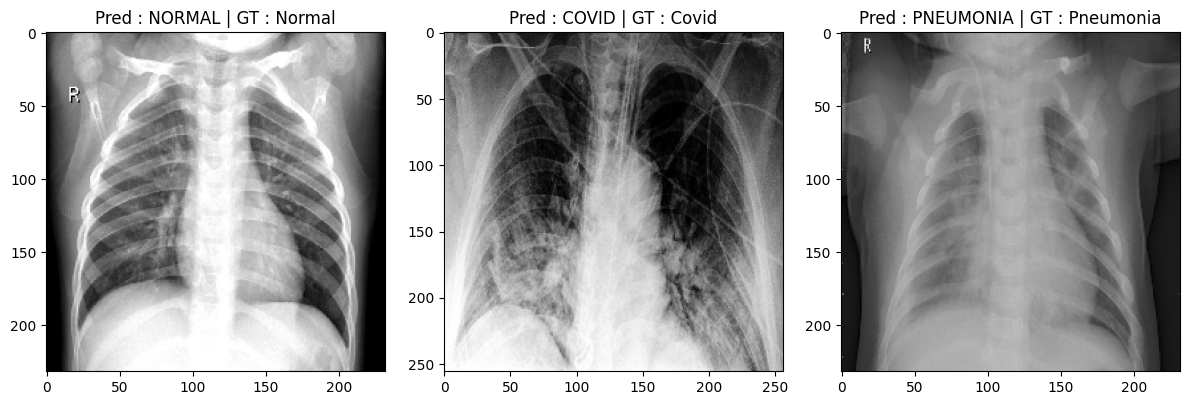

In [57]:
min_num_files = min(len(test_normals_list), len(test_covids_list), len(test_pneumonia_list))

@interact(index=(0, min_num_files-1))
def show_result(index=0):
  normal_image = get_RGB_image(data_data, test_normals_list[index])
  covid_image = get_RGB_image(data_data, test_covids_list[index])
  pneumonia_image = get_RGB_image(data_data, test_pneumonia_list[index])

  pred_normal = model_predict(normal_image, model)
  pred_covid = model_predict(covid_image, model)
  pred_pneumonia = model_predict(pneumonia_image, model)

  plt.figure(figsize=(12,8))
  plt.subplot(131)
  plt.title(f"Pred : {class_list[pred_normal]} | GT : Normal")
  plt.imshow(normal_image)

  plt.subplot(132)
  plt.title(f"Pred : {class_list[pred_covid]} | GT : Covid")
  plt.imshow(covid_image)

  plt.subplot(133)
  plt.title(f"Pred : {class_list[pred_pneumonia]} | GT : Pneumonia")
  plt.imshow(pneumonia_image)
  plt.tight_layout()